# Armita Bahrudi - 810100591

Artificial Intelligence - CA#05: *Convolution Nural Networks* - fall 1402 \
In this notebook, We use CNN to build a Brain Tumor Detector using MRI Images.

In [127]:
import cv2
import glob
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [128]:
from sklearn import metrics
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader, ConcatDataset

## Data Preprocessing

In [129]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
DATA_PATH = '/content/drive/MyDrive/AI-CA5-Dataset'
LABELS = ['glioma', 'meningioma', 'notumor', 'pituitary']
EPOCHES = 70
TEST_RATE = 0.2
LEARNING_RATE = 0.001

### Create Torch Dataset Class

In [131]:
class MRI(Dataset):

  def __init__(self):
    self.x_train, self.y_train, self.x_val, self.y_val = None, None, None, None

    self.mode = 'train'

    dataset = []
    labels = []
    for l in range(len(LABELS)):
      address = DATA_PATH + '/' + LABELS[l] + '/*.jpg'
      lable_images = []
      lable = []
      for i in glob.iglob(address):
        img = cv2.imread(i)
        img = cv2.resize(img, (512,512))
        b, g, r = cv2.split(img)
        img = cv2.merge ([r, g, b])
        lable_images.append(img)
        lable.append(l)
      lable_images = np.array(lable_images)
      lable = np.array(lable)
      dataset.append(lable_images)
      labels.append(lable)

    self.images = np.concatenate((dataset[0], dataset[1], dataset[2], dataset[3]), axis=0)
    self.labels = np.concatenate((labels[0], labels[1], labels[2], labels[3]))
    self.train_val_split()

  def train_val_split(self):
    self.x_train, self.x_val, self.y_train, self.y_val = \
    train_test_split(self.images, self.labels, stratify=self.labels, test_size=TEST_RATE, random_state=42)

  def __len__(self):
    if self.mode == 'train':
      return self.x_train.shape[0]
    elif self.mode == "val":
      return self.x_val.shape[0]

  def __getitem__(self, index):

    if self.mode== 'train':
      sample = {'image': self.x_train[index], "label": self.y_train[index]}
    elif self.mode== "val":
      sample = {'image': self.x_val[index], "label": self.y_val[index]}
    else:
      raise ValueError("Undefined Data Mode")
    return sample

  def normalize(self):
    self.images = self.images / 225.0

  def addlabels(self,ls, counts):
    for i in range(len(ls)):
      plt.text(i, counts[i]//2, counts[i], ha = 'center')

  def show_data_plot(self):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    plt.subplot(1, 2, 1)
    unique, counts = np.unique(self.y_train, return_counts=True)
    plt.bar(LABELS, counts, color="#79CBCD")
    self.addlabels(LABELS, counts)
    plt.title("train")
    plt.subplot(1, 2, 2)
    unique, counts = np.unique(self.y_val, return_counts=True)
    plt.bar(LABELS, counts, color="#FFCAD4")
    self.addlabels(LABELS, counts)
    plt.title("test")
    plt.show()

  def show_sample_images(self):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,5))

    for i, ax in enumerate(axes.flat):
      idx = (mri.y_train == i).nonzero()[0][0]
      ax.imshow(self.x_train[idx])
      ax.set_title(LABELS[self.y_train[idx]])
      ax.axis('off')

In [132]:
mri = MRI()

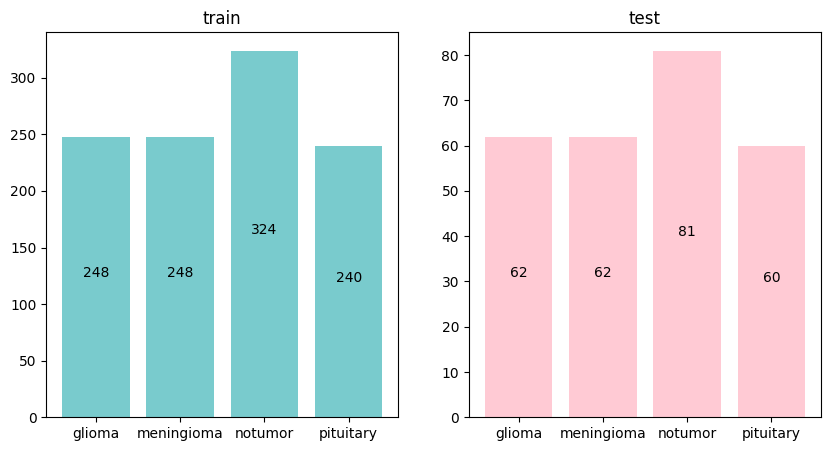

In [133]:
mri.show_data_plot()

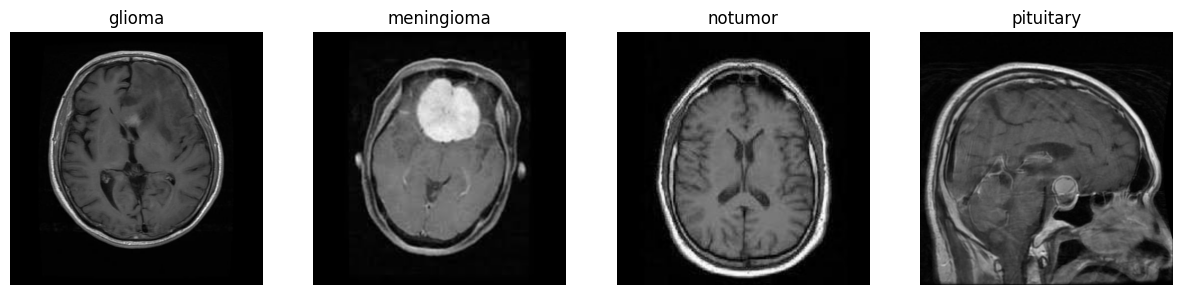

In [134]:
mri.show_sample_images()

### Normalizing pictures

**Normalization (Min-Max Scaling)**:
   - **Formula**: $$x_i = \frac{x_i - min(X)}{max(X) - min(X)}$$
   - **Range**: Transforms features to a specific range (commonly $[0,1]$ or $[-1,1]$).
   - **Use Case**: Particularly useful when the features have a bounded minimum and maximum value.
   
#### Benefits of Normalization:
1. Strengthening Machine Learning Algorithms: Normalization can improve the behavior and performance of machine learning algorithms, especially neural networks.
2. Preserving Value Scales: It ensures that pixel values fall within a consistent range, aiding in generalization across images of different scales.
3. Noise Resistance: It can enhance resistance against small variations in brightness and contrast, thus improving robustness against noise.

#### Drawbacks:
1. Adding Complexity to Models: In some cases, normalization may increase model complexity and computational cost.
2. Improper Usage: Incorrect application of normalization can lead to model dependency on specific scaling and transformations.
3. Loss of Local Information: It might cause loss of some local and specific image information, possibly reducing overall image quality.

In conclusion, the use of normalization should be carefully considered based on the specific problem and image types under investigation. Additionally, combining normalization with techniques such as data augmentation and regularization can further improve model performance.

In [135]:
#mri.normalize()

## Creat tumor detector model



In [148]:
import torch.nn as nn
import torch.nn. functional as F

In [149]:
class CNN(nn.Module):
  def __init__(self):
    super (CNN, self) .__init__()

    self.cnn_layer = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),#508
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2, stride=5),#102
    nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),#98
    nn.Tanh(),
    nn.MaxPool2d(kernel_size=2, stride=5),#20
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),#16
    nn.Tanh(),
    nn.AvgPool2d(kernel_size=2, stride=5))#3

    self.fc_layer = nn.Sequential(
        nn.Linear(in_features=288, out_features=120),
        nn.Tanh(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=4))

  def forward(self, x):
    x = self.cnn_layer(x)
    x = torch.flatten(x,1)
    x = self.fc_layer(x)
    x = F.softmax(x, dim=1)
    return x



### Network's Architecture

- MaxPool2d selects the maximum value from each sub-region, emphasizing the most active features within the region.
- AvgPool2d calculates the average value from each sub-region, providing a smoother down-sampling approach.

#### Activation Function

1. ReLU (Rectified Linear Unit):
   - This is one of the most widely used activation functions in CNNs due to its simplicity and effectiveness. ReLU sets all negative values to zero and leaves positive values unchanged.
   - It works well in many scenarios, including multi-class classification, as it helps with the vanishing gradient problem and accelerates the convergence of stochastic gradient descent. 

2. Leaky ReLU:
   - Leaky ReLU is an extension of the ReLU function that allows a small gradient for negative inputs.
   - In the context of multi-class CNNs, Leaky ReLU can prevent dead neurons (those that never activate) and can help with the training of deeper networks.

3. ELU (Exponential Linear Unit):
   - ELU is another variant of the ReLU function that has an exponential component for negative inputs, which allows it to take negative values. This can provide better learning representation compared to traditional ReLU.
   - For multi-class CNNs, ELU can help in learning more complex representations, which might be beneficial in scenarios where the input data has varying levels of complexity across different classes.

4. Softmax:
   - Now, this one is particularly essential for multi-class classification at the output layer. The softmax function takes a vector of arbitrary real-valued scores and squashes it into a vector of values between zero and one that sum to one. This allows the output to be interpreted as probabilities.
   - In the context of a multi-class CNN, the softmax activation in the output layer is crucial for generating class probabilities, which plays a vital role in determining the predicted class for a given input.

### Regularization Function

- Batch Normalization:
    - Batch Normalization is a technique that normalizes the input of each layer at the mini-batch level. It addresses the issue of internal covariate shift, which is the change in the distribution of network activations as the parameters of preceding layers change during training. By normalizing the inputs of each layer, Batch Normalization enables faster and more stable training of deep neural networks.

    - The core idea of Batch Normalization is to transform the inputs of a layer to have a mean close to zero and standard deviation close to one. This is achieved by computing the mean and variance of the inputs within a mini-batch and then applying the normalization using learned scale and shift parameters.

- Dropout:
    - Dropout is a regularization technique used during training to prevent overfitting. It works by randomly setting a fraction of the input units to zero at each update during training, effectively "dropping out" a portion of the network. This forces the network to learn more robust features and prevents it from relying too much on any individual unit.

    - During inference (or when making predictions), the dropout is turned off, and the full network is used for prediction, thus ensuring that all units are active. This technique helps the network generalize better to unseen data and reduces the likelihood of overfitting.


In [150]:
device = torch.device ('cuda:0' if torch.cuda.is_available() else 'cpu')
detector = CNN().to(device)

In [151]:
optimizer = torch.optim.Adam(detector.parameters(), lr=LEARNING_RATE)
train_dataloader = DataLoader(mri, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri, batch_size=32, shuffle=False)

In [152]:
epoch_train_loss = []
epoch_val_loss = []
epoch_train_accuracy = []
epoch_test_accuracy = []

In [153]:
for epoch in range(EPOCHES):
  train_losses = []
  train_accuracy = []
  detector.train()
  mri.mode = 'train'
  for d in train_dataloader:
    optimizer.zero_grad()
    imgs = (d['image'] / 255).type(torch.float32).to(device)
    imgs = imgs.permute(0, 3, 1, 2)
    labels = d['label'].to(device)
    y_hat = detector(imgs)
    error = nn.CrossEntropyLoss()
    loss = torch.sum(error(y_hat, labels))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    predictions = y_hat.cpu().detach().numpy()
    predictions = np.argmax(predictions, axis=1)
    labels = labels.cpu().detach().numpy()
    train_accuracy.append(accuracy_score(labels, predictions))
  epoch_train_loss.append(np.mean(train_losses))
  epoch_train_accuracy.append(np.mean(train_accuracy))

  test_losses = []
  test_accuracy = []
  detector.eval()
  mri.mode = 'val'
  with torch.no_grad():
    for d in val_dataloader:
      imgs = (d['image'] / 255).type(torch.float32).to(device)
      imgs = imgs.permute(0, 3, 1, 2)
      labels = d['label'].to(device)
      y_hat = detector(imgs)
      error = nn.CrossEntropyLoss()
      loss = torch.sum(error(y_hat, labels))
      test_losses.append(loss.item())
      predictions = y_hat.cpu().detach().numpy()
      predictions = np.argmax(predictions, axis=1)
      labels = labels.cpu().detach().numpy()
      test_accuracy.append(accuracy_score(labels, predictions))
  epoch_val_loss.append(np.mean(test_losses))
  epoch_test_accuracy.append(np.mean(test_accuracy))

  if (epoch+1) % 10 == 0:
    test_acc_av = np.mean(test_accuracy)
    print('Train Epoch: {}\tTrain Loss: {:.6f}\tTest Loss: {:.6f}'. format(epoch+1, np.mean(train_losses), np.mean(test_losses)))
    print('Train Epoch: {}\tTrain Accuracy: {:.6f}\tTest Accuracy: {:.6f}'. format(epoch+1, np.mean(train_accuracy), test_acc_av))

Train Epoch: 10	Train Loss: 1.087202	Test Loss: 1.062413
Train Epoch: 10	Train Accuracy: 0.648897	Test Accuracy: 0.685185
Train Epoch: 20	Train Loss: 1.015960	Test Loss: 1.037351
Train Epoch: 20	Train Accuracy: 0.721507	Test Accuracy: 0.702160
Train Epoch: 30	Train Loss: 0.936699	Test Loss: 1.008539
Train Epoch: 30	Train Accuracy: 0.814338	Test Accuracy: 0.731867
Train Epoch: 40	Train Loss: 0.906628	Test Loss: 1.008984
Train Epoch: 40	Train Accuracy: 0.836397	Test Accuracy: 0.729938
Train Epoch: 50	Train Loss: 0.861337	Test Loss: 1.007413
Train Epoch: 50	Train Accuracy: 0.879596	Test Accuracy: 0.724923
Train Epoch: 60	Train Loss: 0.828286	Test Loss: 0.973152
Train Epoch: 60	Train Accuracy: 0.913603	Test Accuracy: 0.764660
Train Epoch: 70	Train Loss: 0.809715	Test Loss: 0.971529
Train Epoch: 70	Train Accuracy: 0.935662	Test Accuracy: 0.777006


### Loss function

1. Binary Cross Entropy Loss (BCELoss): If you are dealing with a binary classification problem (where each input sample can belong to only one of two classes), you can use BCELoss instead of CrossEntropyLoss. BCELoss is often used with a sigmoid activation function in the output layer.

2. Hinge Embedding Loss (HingeEmbeddingLoss): It's used for training classifiers, particularly in support vector machines (SVMs), and encourages the correct class to have a higher score than the incorrect classes by at least a margin.

3. Kullback-Leibler Divergence Loss (KLDivLoss): This loss function measures the difference between two probability distributions. It can be used when the output of the model needs to approximate a specific target distribution.

4. Mean Squared Error Loss (MSELoss): This loss function is commonly used for regression problems and can be suitable when the problem involves predicting continuous target values rather than class labels.


CrossEntropyLoss is a commonly used loss function, especially for multi-class classification problems. It's often used in conjunction with the softmax activation function in the output layer of a neural network.

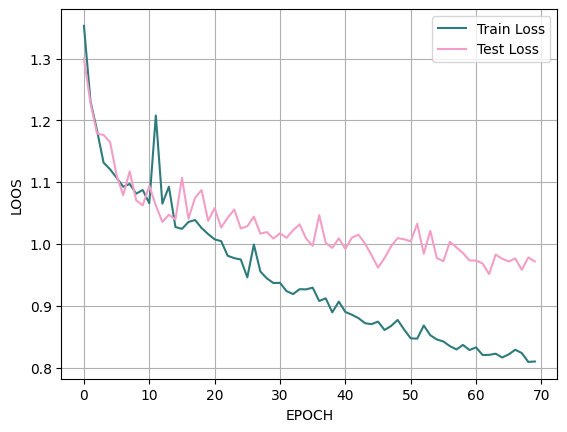

In [154]:
plt.plot(epoch_train_loss, c="#2E7B7C", label='Train Loss')
plt.plot(epoch_val_loss, c="#F39EC7", label='Test Loss')
plt.legend()
plt.grid()
plt.xlabel('EPOCH')
plt.ylabel('LOOS')
plt.show()

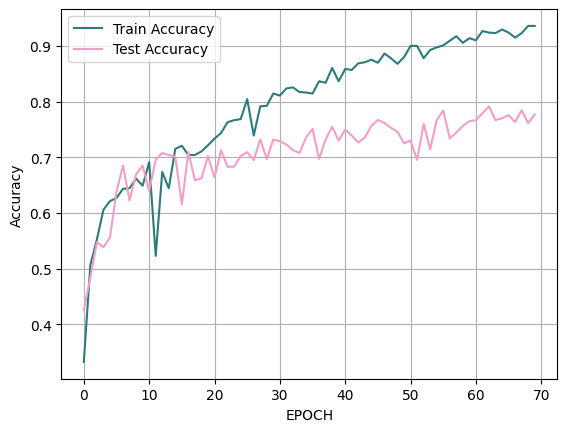

In [155]:
plt.plot(epoch_train_accuracy, c="#2E7B7C", label='Train Accuracy')
plt.plot(epoch_test_accuracy,  c="#F39EC7", label='Test Accuracy')
plt.legend()
plt.grid()
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.show()

In [156]:
detector.eval()
predicted_labels = []
true_labels = []

mri.mode = 'val'
with torch.no_grad():
  for d in val_dataloader:
    imgs = (d['image'] / 255).type(torch.float32).to(device)
    labels = d['label'].to(device)
    imgs = imgs.permute(0, 3, 1, 2)
    y_hat = detector(imgs)
    predicted_labels.append(y_hat.cpu().detach().numpy())
    true_labels.append(labels.cpu().detach().numpy())

In [157]:
predicted_labels = np.concatenate(predicted_labels, axis=0).squeeze()
true_labels = np.concatenate(true_labels, axis=0).squeeze()

In [158]:
predicted_labels = np.argmax(predicted_labels,axis=1)
accuracy_score(true_labels, predicted_labels)

0.7962264150943397

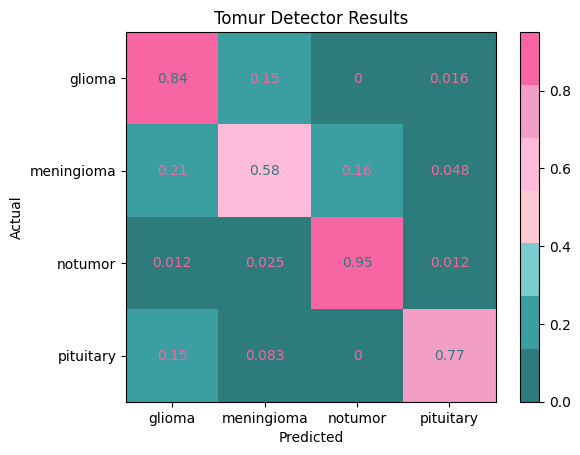

              precision    recall  f1-score   support

      glioma       0.69      0.84      0.76        62
  meningioma       0.69      0.58      0.63        62
     notumor       0.89      0.95      0.92        81
   pituitary       0.90      0.77      0.83        60

    accuracy                           0.80       265
   macro avg       0.79      0.78      0.78       265
weighted avg       0.80      0.80      0.79       265



In [159]:
m = confusion_matrix(true_labels, predicted_labels )
normalized_cm = m.astype('float') / m.sum(axis=1)[:, np.newaxis]
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=normalized_cm, display_labels=LABELS)
palette = ["#2E7B7C", "#3B9EA0", "#79CBCD", "#FFCAD4", "#FFBCDA", "#F39EC7", "#F765A3"]
color_map = mcolors.ListedColormap(palette)
disp.plot(cmap=color_map)
plt.title('Tomur Detector Results')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(metrics.classification_report(true_labels, predicted_labels, target_names=LABELS))